<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Intent" data-toc-modified-id="Intent-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Intent</a></span></li><li><span><a href="#Learnings" data-toc-modified-id="Learnings-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Learnings</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#BAV-Data-Pre-Processing" data-toc-modified-id="BAV-Data-Pre-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BAV Data Pre-Processing</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Quick-look-at-the-data" data-toc-modified-id="Quick-look-at-the-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Quick look at the data</a></span></li><li><span><a href="#Encoding" data-toc-modified-id="Encoding-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Encoding</a></span></li><li><span><a href="#Isolating-the-Target-Variable" data-toc-modified-id="Isolating-the-Target-Variable-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Isolating the Target Variable</a></span></li><li><span><a href="#PCA-With-Scaling" data-toc-modified-id="PCA-With-Scaling-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>PCA With Scaling</a></span></li><li><span><a href="#PCA-Without-Scaling" data-toc-modified-id="PCA-Without-Scaling-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>PCA Without Scaling</a></span></li></ul></li><li><span><a href="#PCA-Correlation-with-Features" data-toc-modified-id="PCA-Correlation-with-Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA Correlation with Features</a></span></li><li><span><a href="#Factor-Analysis" data-toc-modified-id="Factor-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Factor Analysis</a></span><ul class="toc-item"><li><span><a href="#Factoring-Down-to-8" data-toc-modified-id="Factoring-Down-to-8-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Factoring Down to 8</a></span></li><li><span><a href="#Inspecting-and-Naming-the-Factors" data-toc-modified-id="Inspecting-and-Naming-the-Factors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Inspecting and Naming the Factors</a></span></li></ul></li><li><span><a href="#Hypothesis-on-Data-Leakage" data-toc-modified-id="Hypothesis-on-Data-Leakage-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hypothesis on Data Leakage</a></span></li><li><span><a href="#Next-Steps" data-toc-modified-id="Next-Steps-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Next Steps</a></span><ul class="toc-item"><li><span><a href="#File-Save-Outs" data-toc-modified-id="File-Save-Outs-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>File Save Outs</a></span></li></ul></li></ul></div>

## Summary

### Intent

- The goal of this notebook is to reduce the dimensionality of the BAV data and address any data scaling issues.


- Techniques explored include PCA with 2 components and PCA at a 90% explained variance threshold (determined by SKLearn) on both scaled and unscaled data.   


- After PCA, Factor Analysis was conducted to help determine the underlying features that makeup each factor. This was successful and allowed for about 70% of the variance to be explained with a reduction to 8 factors.   


- The Factor Analysis also helped point out and address some potential data leakage. A second round of Factor Analysis was run on a reduction of 6 features from the raw dataset. Removing the '_C' columns of "Esteem", "Knowledge", "Relevance", "Differentiation", "Strength", and "Stature" that are made-up of the other features in the BAV survey dataset.

### Learnings

- Overall, the PCA worked to explain more variance in the dataset without scaling than with. However, while the reduction from 55 features to 15 was significant, the loss in interpretability was drastic. The results of modeling data in this form would be difficult to explain and impossible to interpret—which is important to understand the data going into the model.   


- Because of the loss of interpretablilty, Factor Analysis was conducted. the results were 8 distinct factors/clusters that explain about 70% of the variance in the features. While there's a bit more thinking to do on the names of these factors, this is promising and will be brought forward into the modeling phase. 


- This Factor analysis was repeated to address possible data leakage. This was done by removing a few of the strongest/most impactful columns. The reason was to take out the features that were not part of the raw survey data as this may be redundnant as they are made up of the results in the other columns. This performed almost as well in terms of explaining total variance (-1%) but resulted in an output that was even clearer to interpret.

### Data

- Year column was encoded. 'year' is now 'yr_2019' encoded with a 1 if true or 0 if 2018.

- Factor Analysis reduced the number of features from 55 to 8. Factor names are still a work in progress, but directionally, something like this:  

>Factor 0: Service  
Factor 1: Cutting Edge  
Factor 2: Quality  
Factor 3: Prestige  
Factor 4: Uniqueness  
Factor 5: Charisma  
Factor 6: Powerful  
Factor 7: Thoughtful  

## BAV Data Pre-Processing

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os
import numpy as np
import time

from pandas_datareader import data as pdr
from scipy.stats import norm
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

### Quick look at the data

In [2]:
# Load the Joined BAV data from EDA stage
BAV_df = pd.read_csv('../data/BAV_join.csv', header=0, index_col=0)
BAV_df.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,Year
Acura,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,8.301122,...,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,2018
Alfa Romeo,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,13.124450,...,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,2018
Aston Martin,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,13.061050,...,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,2018
Audi,8.403893,0.773740,1.970076,0.536370,3.247704,1.741970,1.524328,9.503444,16.048050,11.872650,...,18.800541,8.386318,15.85582,12.400040,6.730000,10.951970,21.809719,11.357830,8.388798,2018
Bentley,6.453038,0.790917,1.605834,0.500165,2.720615,1.360756,1.270082,11.227820,19.309050,14.956740,...,19.569870,11.032830,12.52582,12.685470,11.473560,9.141562,34.941780,9.720911,10.133530,2018


In [3]:
BAV_df.describe()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,Year
count,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,...,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000
mean,12.209701,0.588415,2.544035,0.477370,2.414359,1.303382,1.505913,9.397467,11.285562,9.608629,...,7.968883,10.177757,12.280784,15.192883,5.445757,10.849244,8.087944,10.250318,6.298799,2018.500000
std,8.713072,0.121253,0.537333,0.212133,1.138746,1.146969,0.487146,2.483562,2.635689,2.600862,...,4.555316,4.021893,4.398676,5.227095,2.280908,2.704662,4.441919,3.231548,2.558453,0.500041
min,0.000000,0.311086,0.844490,0.040534,0.361947,0.063010,0.323127,1.993662,3.848764,2.237904,...,0.957738,2.520318,1.168887,2.830153,0.000000,0.743542,0.777813,1.619330,0.000000,2018.000000
25%,5.847472,0.504416,2.194867,0.336441,1.405593,0.481978,1.182708,7.553335,9.481501,7.762816,...,5.082789,7.423602,9.070712,11.420812,4.006169,9.046549,5.456322,8.055205,4.471148,2018.000000
50%,9.905344,0.571779,2.465221,0.420696,2.403746,0.934364,1.435254,8.978947,10.893910,9.208430,...,6.409295,9.271638,11.455115,14.337950,4.950425,10.536130,6.766305,9.639658,5.844792,2018.500000
75%,16.737939,0.651827,2.809550,0.566624,3.309856,1.711841,1.739238,10.843252,12.596953,11.000907,...,9.035676,11.916027,14.547902,18.198491,6.349181,12.262418,9.034813,11.721245,7.648178,2019.000000
max,50.524490,1.298806,5.316035,1.729260,5.400015,9.338032,6.904500,27.744989,29.265770,28.022829,...,32.493820,44.155819,33.851509,38.595451,30.147461,24.366600,39.617592,31.832420,20.036560,2019.000000


In [4]:
BAV_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, Acura to Thomson Reuters
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Recommend_to_a_friend_pct    6058 non-null   float64
 1   Energized_Differentiation_C  6058 non-null   float64
 2   Relevance_C                  6058 non-null   float64
 3   Esteem_C                     6058 non-null   float64
 4   Knowledge_C                  6058 non-null   float64
 5   Brand_Stature_C              6058 non-null   float64
 6   Brand_Strength_C             6058 non-null   float64
 7   Different_pct                6058 non-null   float64
 8   Distinctive_pct              6058 non-null   float64
 9   Unique_pct                   6058 non-null   float64
 10  Dynamic_pct                  6058 non-null   float64
 11  Innovative_pct               6058 non-null   float64
 12  Leader_pct                   6058 non-null   float64
 13  Reliable

### Encoding

First clean-up is the 'year' column. While it's a number, the scale is drastically different.

In [5]:
# Change 'year' to 'yr_2019' encoded with a 1 if true or 0 if 2018.
BAV_df['yr_2019'] = BAV_df['Year'].apply(lambda x: 0 if x==2018 else 1)

In [6]:
print(BAV_df['yr_2019'].sample(10))

One-A-Day                     0
Esquire                       1
Toray                         0
Abercrombie & Fitch           0
Champion (sports clothing)    0
Froot Loops                   0
ticketmaster.com              0
Star Trek: Discovery          0
Glamour                       0
Zuke`s                        1
Name: yr_2019, dtype: int64


In [7]:
BAV_df['yr_2019'].value_counts()

0    3029
1    3029
Name: yr_2019, dtype: int64

An even and equall number of 0s and 1s. As expected.  
Now drop the relic 'Year' column.

In [8]:
BAV_df = BAV_df.drop(['Year'], axis=1)
BAV_df.head(3)

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Acura,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,8.301122,...,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,0
Alfa Romeo,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,13.124450,...,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,0
Aston Martin,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,13.061050,...,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,0


### Isolating the Target Variable

In [9]:
X = BAV_df.drop(['Recommend_to_a_friend_pct'], axis=1)
y = BAV_df['Recommend_to_a_friend_pct']

### PCA With Scaling

Before modeling, exploring ways to reduce the dimensionality of the dataset to simplify and speed up the process.   
Starting with a Principal Component Analysis.

In [10]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Start with scaling to 2 components
pca = PCA(n_components=2)
pc_train = pca.fit_transform(X_train)
principalComponents = pca.transform(X_test)
principal_BAV = pd.DataFrame(data = principalComponents, columns = ['pc 1', 'pc 2'])

In [12]:
y_test = pd.DataFrame(y_test)
principal_BAV.index = y_test.index

In [13]:
BAV_pca2_df = pd.concat([principal_BAV, y_test], axis=1)

In [14]:
BAV_pca2_df.sample(10)

,pc 1,pc 2,Recommend_to_a_friend_pct
Samsung Galaxy,7.667615,4.432232,25.485830
Paychex,-2.268433,-0.384584,5.416668
Swatch,-2.653309,1.601018,8.037248
Barack Obama,9.004761,5.933246,0.000000
Italy,-0.055835,4.378889,16.667589
Beggin` Strips,-1.408673,-2.913324,15.280130
Cesar,-5.193408,-2.986282,8.415092
Geox,0.316310,3.858544,3.621675
Health Guru,-1.657656,0.557177,4.091252
C-Span,-4.639428,-1.540581,7.723294


In [15]:
# Ensuring we still have the same number of columns as before (30% of 6058 = 1818)
BAV_pca2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1818 entries, Priceless Los Angeles to NFL Network
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pc 1                       1818 non-null   float64
 1   pc 2                       1818 non-null   float64
 2   Recommend_to_a_friend_pct  1818 non-null   float64
dtypes: float64(3)
memory usage: 56.8+ KB


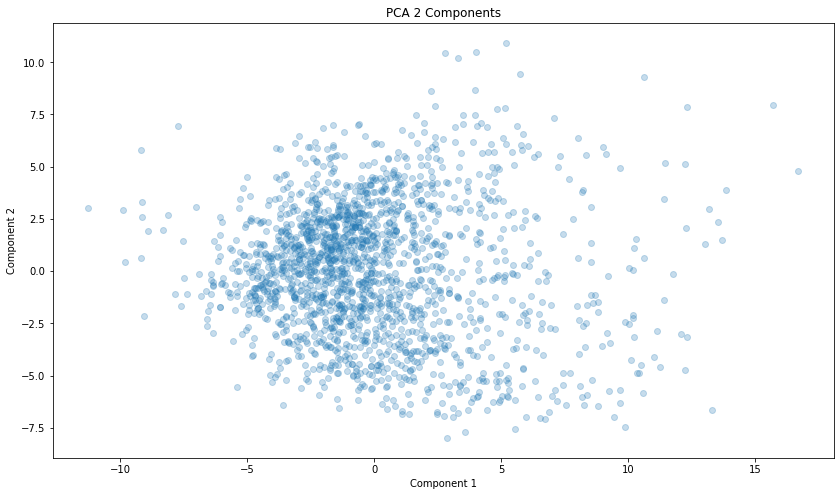

In [16]:
figure(figsize=(14, 8))
plt.scatter(BAV_pca2_df['pc 1'], BAV_pca2_df['pc 2'], alpha=.25)
plt.title('PCA 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [17]:
pca.explained_variance_ratio_

array([0.2526526, 0.1784826])

In [18]:
print('Makes more sense why the 2 component PCA is largely a blob. The explained variance is only {}. Will have to try with a larger number of components'.format(pca.explained_variance_ratio_.sum()))

Makes more sense why the 2 component PCA is largely a blob. The explained variance is only 0.4311351926492036. Will have to try with a larger number of components


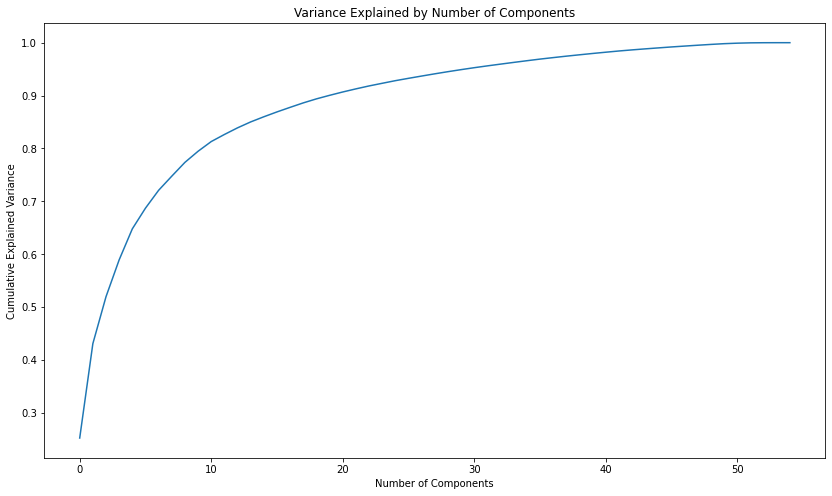

In [19]:
# Have SKLearn select the number of components to explain 90% of the variance
# Start by visualizing
pca = PCA()
pca_train = pca.fit(X_train)
pca_test = pca.transform(X_test)
figure(figsize=(14, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variance Explained by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
plt.show()

Looks like 20 components will explain about 90% of the variance.  
Let's find out exactly how many.

In [20]:
pca = PCA(n_components = 0.9)
pca_train = pca.fit(X_train)
pca_test = pca.transform(X_test)
pca.n_components_

20

In [21]:
# Reassemble X and y with 21 components
X = pd.DataFrame(data = pca.transform(X))
y = pd.DataFrame(y)
X.index = y.index
BAV_pca21_df = pd.concat([X, y], axis=1)

In [22]:
BAV_pca21_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, Acura to Thomson Reuters
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   0                          6058 non-null   float64
 1   1                          6058 non-null   float64
 2   2                          6058 non-null   float64
 3   3                          6058 non-null   float64
 4   4                          6058 non-null   float64
 5   5                          6058 non-null   float64
 6   6                          6058 non-null   float64
 7   7                          6058 non-null   float64
 8   8                          6058 non-null   float64
 9   9                          6058 non-null   float64
 10  10                         6058 non-null   float64
 11  11                         6058 non-null   float64
 12  12                         6058 non-null   float64
 13  13                         6058 non-nu

In [23]:
BAV_pca21_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Recommend_to_a_friend_pct
Busy Bone,57.922533,6.302733,-18.166521,0.068458,-0.116363,6.170823,6.924192,-10.917561,-1.705687,5.680547,...,-8.582318,1.822912,1.571756,12.297558,8.152943,-6.567973,-1.916297,14.548013,-2.805872,7.941915
Google Maps,88.425283,10.474036,6.821082,-10.316905,-6.151862,3.878109,-7.885949,-13.213913,1.167775,8.368725,...,-2.904958,7.997855,-0.181765,13.946579,14.267294,2.051796,-7.914847,15.931438,-5.716466,43.911911
Indianapolis Colts,41.242421,19.155217,-9.664322,3.426886,17.861879,9.242454,5.836194,-16.906265,-3.083309,3.745297,...,-6.892164,4.330380,-0.606787,6.448352,3.511066,-1.276817,-1.532754,9.846862,-0.770392,7.913261
Mountain Dew,61.946871,14.305420,-20.782432,3.756068,10.806441,7.386086,-0.478373,-6.525085,-1.616826,5.419781,...,-8.767926,5.456762,-2.410986,9.928634,9.272128,-1.484372,-2.818119,15.009372,-2.078811,23.273760
Jif,77.414525,-9.007085,-20.710674,8.550596,-1.238920,12.078242,5.671518,-7.288357,-0.685743,6.349749,...,-9.939301,0.861910,-2.888835,14.064595,6.494305,-9.196985,1.288091,23.169291,-1.170298,36.731480
Gold Medal,73.524685,-12.561926,-10.246325,8.742613,-4.306171,11.291046,6.594941,-8.060090,-0.729529,9.980596,...,-7.321875,4.695355,-0.981232,11.398886,6.895143,-6.281976,-2.819411,21.231210,-0.346568,28.316540
NFL.com,51.565982,20.694574,-6.426596,3.018956,11.328964,10.279853,-0.764629,-13.508066,-0.840798,7.827094,...,-9.094970,3.986670,-4.286226,10.510248,3.899778,-0.443127,-0.017775,12.613516,-1.673084,15.178660
Coors Light,53.906577,8.267480,-19.530251,3.838372,6.964191,11.326586,-1.908031,-9.705347,-0.821580,8.150915,...,-11.455503,3.602904,-4.126865,9.980281,5.866418,-0.932093,-3.647038,14.592275,-0.943565,13.469610
New England Patriots,50.791149,25.095516,-0.991817,9.359069,19.429511,12.691995,6.464246,-16.844643,-1.112253,7.994006,...,-7.845164,2.894074,1.220593,8.994973,3.225567,0.694910,-1.118525,12.314974,-2.530349,11.529850
Nexxus,48.819310,13.490983,-4.172560,7.728321,-9.054874,7.446512,0.127498,-10.255148,-1.777454,5.853569,...,-5.399728,6.059977,-1.893955,8.458631,4.875822,-4.217070,-0.071471,10.489639,-0.349129,11.552280


### PCA Without Scaling

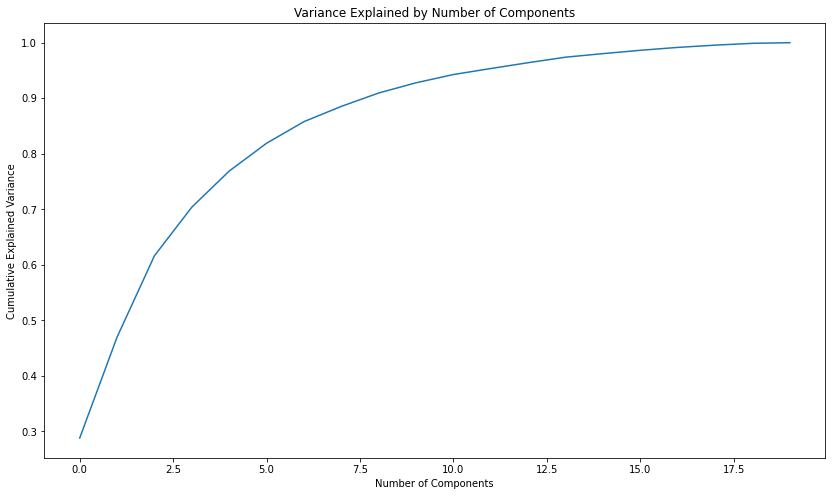

In [24]:
# Have SKLearn select the number of components to explain 90% of the variance
# Start by visualizing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

pca_ns = PCA()
pca_train_ns = pca_ns.fit(X_train)
pca_test_ns = pca_ns.transform(X_test)
figure(figsize=(14, 8))
plt.plot(np.cumsum(pca_ns.explained_variance_ratio_))
plt.title('Variance Explained by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
plt.show()

Without scaling seems to eplain more variance by using less components.  
Let's compute the 90% threshold.

In [25]:
pca_ns = PCA(n_components = 0.9)
pca_train_ns = pca_ns.fit(X_train)
pca_test_ns = pca_ns.transform(X_test)
pca_ns.n_components_

9

In [26]:
# Reassemble DataFrame with 9 components
X = pd.DataFrame(data = pca_ns.transform(X))
y = pd.DataFrame(y)
X.index = y.index
BAV_pca9_df = pd.concat([X, y], axis=1)
BAV_pca9_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, Acura to Thomson Reuters
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   0                          6058 non-null   float64
 1   1                          6058 non-null   float64
 2   2                          6058 non-null   float64
 3   3                          6058 non-null   float64
 4   4                          6058 non-null   float64
 5   5                          6058 non-null   float64
 6   6                          6058 non-null   float64
 7   7                          6058 non-null   float64
 8   8                          6058 non-null   float64
 9   Recommend_to_a_friend_pct  6058 non-null   float64
dtypes: float64(10)
memory usage: 649.6+ KB


In [27]:
BAV_pca9_df.sample(10)

,0,1,2,3,4,5,6,7,8,Recommend_to_a_friend_pct
Husqvarna (tools),6.728353,-2.785728,18.763423,-4.103670,13.643765,-5.849028,-16.241162,1.830393,-7.450831,10.475140
Doritos,18.489376,15.841463,-16.696388,0.608624,7.538185,-3.017746,-1.278849,-4.410526,4.256635,37.754688
TMZ,-19.733091,5.153543,-8.112107,-5.783773,-2.918048,0.193137,-1.078505,2.842304,0.488982,13.681130
Icy Hot,23.876822,-8.668618,8.539260,-2.008471,-4.571327,5.343165,-7.149655,3.337444,2.152204,23.999729
Alka-Seltzer,28.563148,-14.853748,6.818376,0.696584,1.951468,5.017514,0.193697,4.110649,2.599990,21.708120
Honda,15.084568,11.063340,14.317849,-0.915864,3.362122,-7.977994,-9.445406,-2.245722,-3.411721,20.668119
Vespa,-9.318914,5.817170,-5.940992,1.420102,2.032757,-2.057024,-4.861370,0.422519,3.706693,5.345622
Madden NFL,-12.635349,6.847483,-8.660997,-8.876680,5.374931,2.674044,-6.515989,-5.116568,-2.757376,11.462030
Rogue Fitness,-8.077639,-4.498316,-3.350826,1.142462,-2.615158,4.195993,-4.798245,5.596749,-3.430363,3.564236
Bleacher Report,-10.106819,0.281715,-0.329202,-5.861155,-2.119055,-3.256847,-3.400166,0.710854,-1.149458,7.029314


In [28]:
pca_ns.explained_variance_ratio_

array([0.28805779, 0.18180931, 0.146511  , 0.08748723, 0.06500098,
       0.05006502, 0.03891142, 0.02746228, 0.02411677])

The last 2 components aren't contributing very much.   
By dropping these, I can reduce to 7 components and still explain ~85% of the variance.

In [29]:
# Reducing to top 7 components
BAV_pca7_df = BAV_pca9_df.drop([7, 8], axis=1)
BAV_pca7_df.head()

,0,1,2,3,4,5,6,Recommend_to_a_friend_pct
Acura,-6.417492,3.413191,12.255474,6.611602,3.164300,-2.070889,-3.828412,9.632626
Alfa Romeo,-21.235199,10.465603,14.533559,16.552958,8.090853,6.353943,1.810035,5.360558
Aston Martin,-22.621640,9.649502,18.824070,20.599099,11.960422,7.746345,2.437421,6.165359
Audi,-10.786395,12.420994,17.120793,11.604427,6.236877,2.436526,-2.363831,8.403893
Bentley,-17.316586,13.996575,23.831431,24.494712,14.969903,8.403479,7.750624,6.453038


## PCA Correlation with Features

Exploring how the 7 factors correlate with the raw data.

In [32]:
BAV_pca7_df.shape

(6058, 8)

In [33]:
BAV_pca7_df.head()

,0,1,2,3,4,5,6,Recommend_to_a_friend_pct
Acura,-6.417492,3.413191,12.255474,6.611602,3.164300,-2.070889,-3.828412,9.632626
Alfa Romeo,-21.235199,10.465603,14.533559,16.552958,8.090853,6.353943,1.810035,5.360558
Aston Martin,-22.621640,9.649502,18.824070,20.599099,11.960422,7.746345,2.437421,6.165359
Audi,-10.786395,12.420994,17.120793,11.604427,6.236877,2.436526,-2.363831,8.403893
Bentley,-17.316586,13.996575,23.831431,24.494712,14.969903,8.403479,7.750624,6.453038


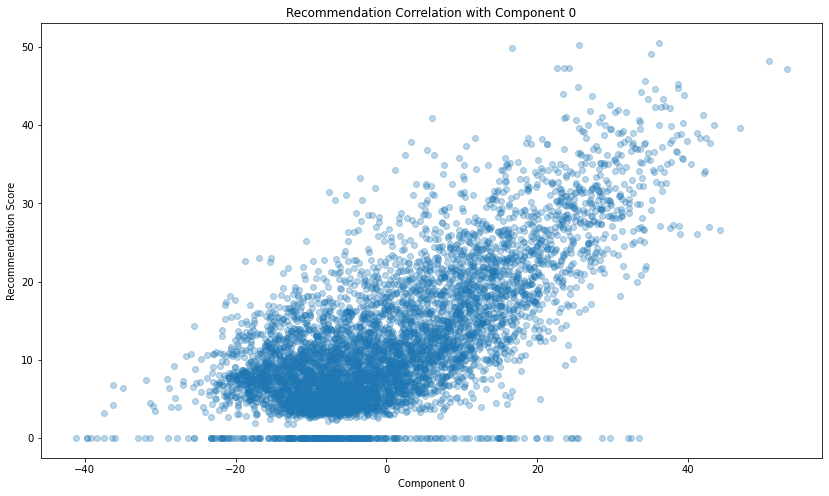

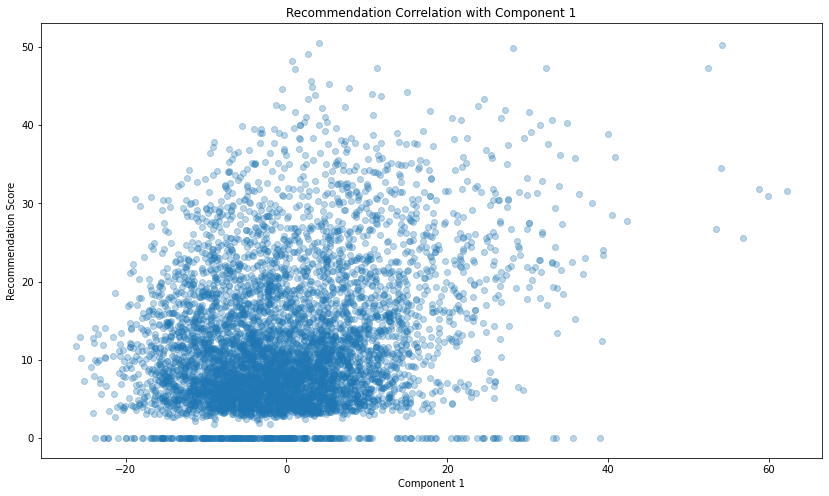

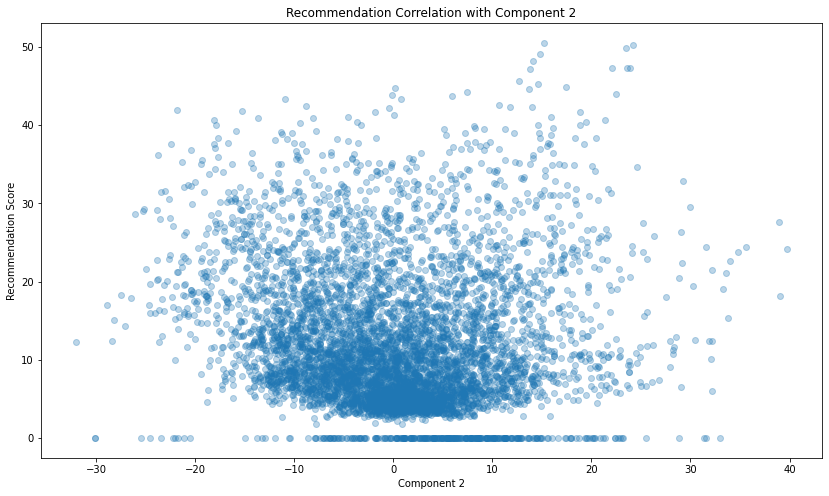

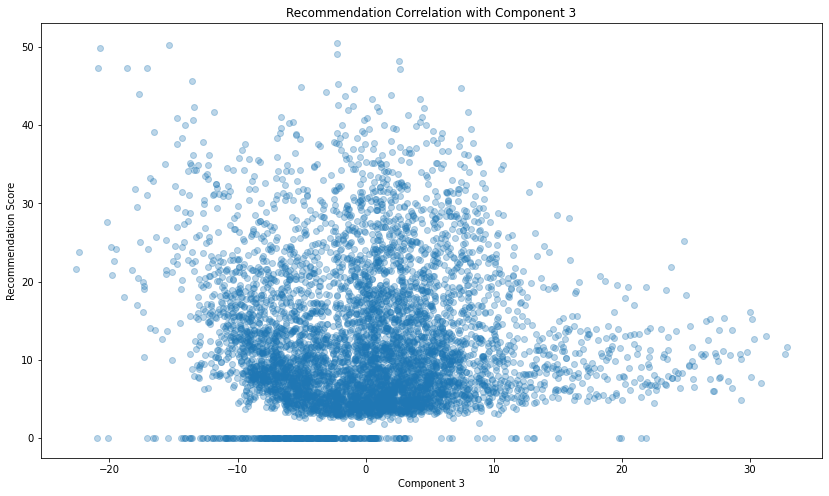

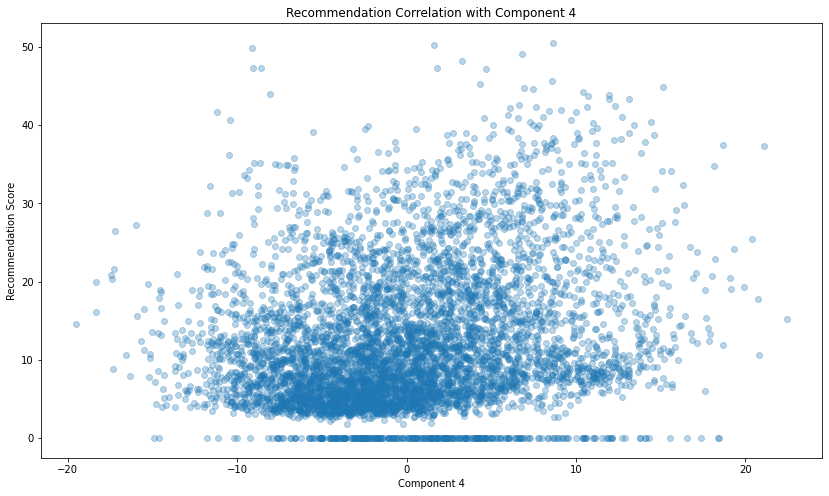

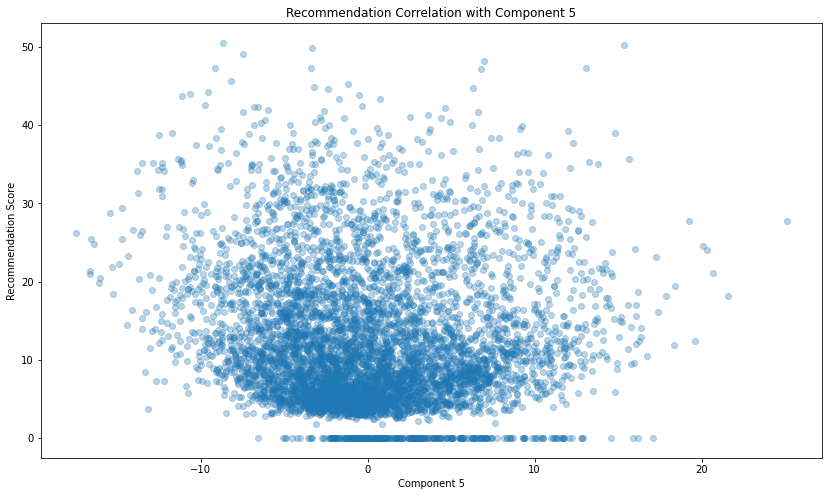

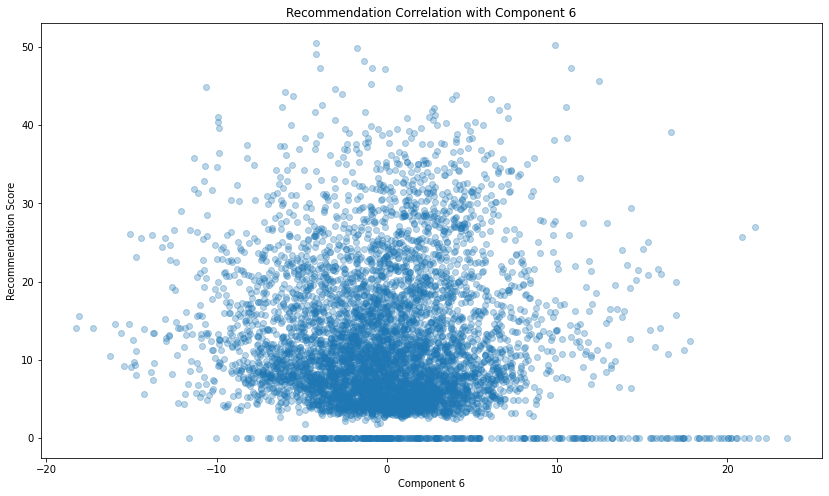

In [35]:
#Visualize each component
for i in range(7):
    plt.figure(figsize=(14, 8))
    plt.scatter(BAV_pca7_df[i], BAV_pca7_df['Recommend_to_a_friend_pct'], alpha=.3)
    plt.title('Recommendation Correlation with Component {}'.format(i))
    plt.xlabel('Component {}'.format(i))
    plt.ylabel('Recommendation Score')
    plt.show()

## Factor Analysis

The loss of interpretablilty in the PCA is disapointing. It doesn't seem like a viable option for dimensionality reduction on the BAV data—at least for explanatory puposes. Before moving into the modeling phase, there is one other technique that may prove valuable to explore in understanding and communicating the workings of the model—Factor Analyisis.   
https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [36]:
# Determining the factorability of the dataset
# Bartlett's Test want a p-value less than .05
BAV_feats = BAV_df.drop(['Recommend_to_a_friend_pct'], axis=1)
chi_square, p_val = calculate_bartlett_sphericity(BAV_feats)
chi_square, p_val

(566685.1813049208, 0.0)

Statistically significant.

In [37]:
# KMO test. Want a value above .6 for factorability
kmo_all, kmo_model = calculate_kmo(BAV_feats)
kmo_model

0.8372072572863931

Great shape for factor analysis.

In [38]:
# Check Eigen Values
fa = FactorAnalyzer(rotation=None)
fa.fit(BAV_feats)

ev, v = fa.get_eigenvalues()
ev

array([1.38066115e+01, 9.92025188e+00, 4.87087987e+00, 3.86464615e+00,
       3.18420891e+00, 2.14374687e+00, 1.85444745e+00, 1.48108949e+00,
       1.42987367e+00, 1.16074250e+00, 9.99327283e-01, 7.35130519e-01,
       6.99874861e-01, 6.14676600e-01, 5.28354029e-01, 4.87438945e-01,
       4.76735642e-01, 4.57506078e-01, 4.11164904e-01, 3.64856260e-01,
       3.56100428e-01, 3.19138582e-01, 3.11238891e-01, 2.75275633e-01,
       2.70601174e-01, 2.50108617e-01, 2.38186219e-01, 2.33778882e-01,
       2.23788400e-01, 2.10112626e-01, 2.04342730e-01, 1.89921809e-01,
       1.82496884e-01, 1.78120143e-01, 1.74988606e-01, 1.71485750e-01,
       1.56303808e-01, 1.51584988e-01, 1.42115507e-01, 1.37242072e-01,
       1.31253676e-01, 1.26464142e-01, 1.19525182e-01, 1.05042373e-01,
       1.03685491e-01, 9.72755677e-02, 9.11870209e-02, 8.83255976e-02,
       8.56285647e-02, 7.95874063e-02, 5.29025467e-02, 3.45053785e-02,
       1.22318492e-02, 3.89009749e-03, 2.72844723e-13])

In [39]:
ev_df = pd.DataFrame(data={'Eigen Value': ev})
ev_df

,Eigen Value
0,1.380661e+01
1,9.920252e+00
2,4.870880e+00
3,3.864646e+00
4,3.184209e+00
5,2.143747e+00
6,1.854447e+00
7,1.481089e+00
8,1.429874e+00
9,1.160742e+00


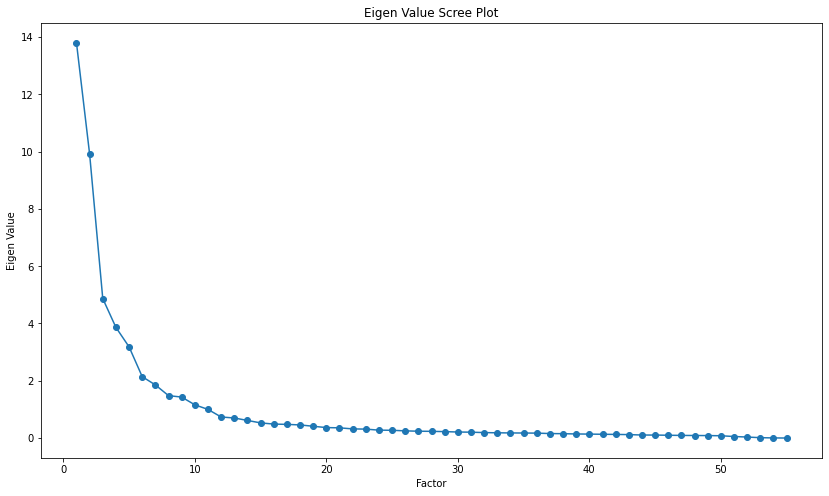

In [40]:
# Plot Eigen Values
plt.figure(figsize=(14, 8))
plt.scatter(range(1, 56), ev)
plt.plot(range(1, 56), ev)
plt.title('Eigen Value Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigen Value')
plt.show()

10 values greater than 1. Let's start with 10 values.

In [41]:
# Run Factor Analysis on 10 Factors
fa = FactorAnalyzer(rotation='varimax', n_factors=10)
fa.fit(BAV_feats)

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [42]:
# Make DataFrame from fa.loadings_
factor_cols = ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7', 'Factor 8', 'Factor 9']
loadings = pd.DataFrame(data=fa.loadings_, columns=factor_cols, index=BAV_feats.columns)
loadings

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
Energized_Differentiation_C,0.074562,0.600220,0.243183,0.692065,0.155306,-0.025440,0.244121,0.044045,-0.084774,0.052332
Relevance_C,0.760829,0.142821,-0.088437,0.103703,0.035553,0.209298,-0.024422,-0.128228,0.201915,0.056563
Esteem_C,0.927414,0.273816,-0.013838,-0.106636,-0.058504,0.113987,0.066824,-0.077101,-0.063524,0.002940
Knowledge_C,0.738543,-0.048422,-0.176310,-0.219086,0.342987,-0.201219,-0.081596,0.112440,-0.015863,-0.045015
Brand_Stature_C,0.937076,0.148811,-0.094489,-0.146700,0.142171,-0.014642,-0.001360,0.042286,-0.011051,-0.022053
Brand_Strength_C,0.555652,0.504153,0.082124,0.501556,0.140367,0.111369,0.147598,-0.030524,0.075061,0.075145
Different_pct,-0.228157,0.263068,0.092875,0.738858,0.106545,0.103367,0.013187,0.078557,0.156148,0.048234
Distinctive_pct,0.374095,0.204360,0.396917,0.509247,0.174363,-0.053991,0.131192,0.116224,-0.282178,0.008049
Unique_pct,0.018069,0.319925,0.254301,0.742992,0.217109,0.063353,0.080572,0.020935,-0.053940,0.050566
Dynamic_pct,0.026011,0.500432,0.150929,0.214405,0.195747,-0.104462,0.614953,0.171503,-0.182238,0.044702


In [44]:
# Get variance for each factor
variance_cols = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
variance = pd.DataFrame(data=fa.get_factor_variance(), columns=loadings.columns, index=variance_cols)
variance

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
SS Loadings,10.920187,6.507013,4.602272,3.766639,3.572142,3.256050,2.629058,2.512881,1.940950,1.423444
Proportion Variance,0.198549,0.118309,0.083678,0.068484,0.064948,0.059201,0.047801,0.045689,0.035290,0.025881
Cumulative Variance,0.198549,0.316858,0.400536,0.469020,0.533968,0.593169,0.640970,0.686659,0.721949,0.747830


Factors 8 and 9 aren't adding much clarity.   
Will try dropping to 8 factors and attempting to spot any clusters or groupings.

### Factoring Down to 8

In [45]:
# Run Factor Analysis on 8 Factors
fa = FactorAnalyzer(rotation='varimax', n_factors=8)
fa.fit(BAV_feats)

FactorAnalyzer(n_factors=8, rotation='varimax', rotation_kwargs={})

In [46]:
# Make DataFrame from fa.loadings_
factor_cols = ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7']
loadings = pd.DataFrame(data=fa.loadings_, columns=factor_cols, index=BAV_feats.columns)

In [47]:
# Get variance for each of the 8 factors
variance_cols = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
variance = pd.DataFrame(data=fa.get_factor_variance(), columns=loadings.columns, index=variance_cols)
variance

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
SS Loadings,10.520583,6.486154,4.528075,4.283831,3.959629,3.377183,3.300201,2.435634
Proportion Variance,0.191283,0.117930,0.082329,0.077888,0.071993,0.061403,0.060004,0.044284
Cumulative Variance,0.191283,0.309213,0.391542,0.469430,0.541423,0.602826,0.662830,0.707114


70% of the variance in 8 factors is pretty good.   
Let's see if we can visualize the feature make up of each.

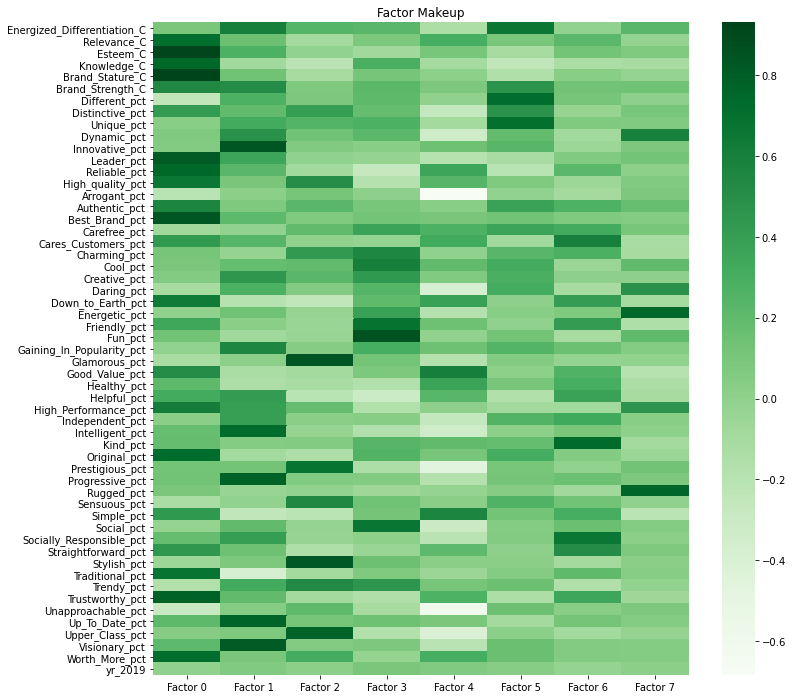

In [48]:
# Visualize
plt.figure(figsize=(12, 12))
sns.heatmap(loadings, cmap='Greens', fmt='g').set_title('Factor Makeup')
plt.show()

### Inspecting and Naming the Factors

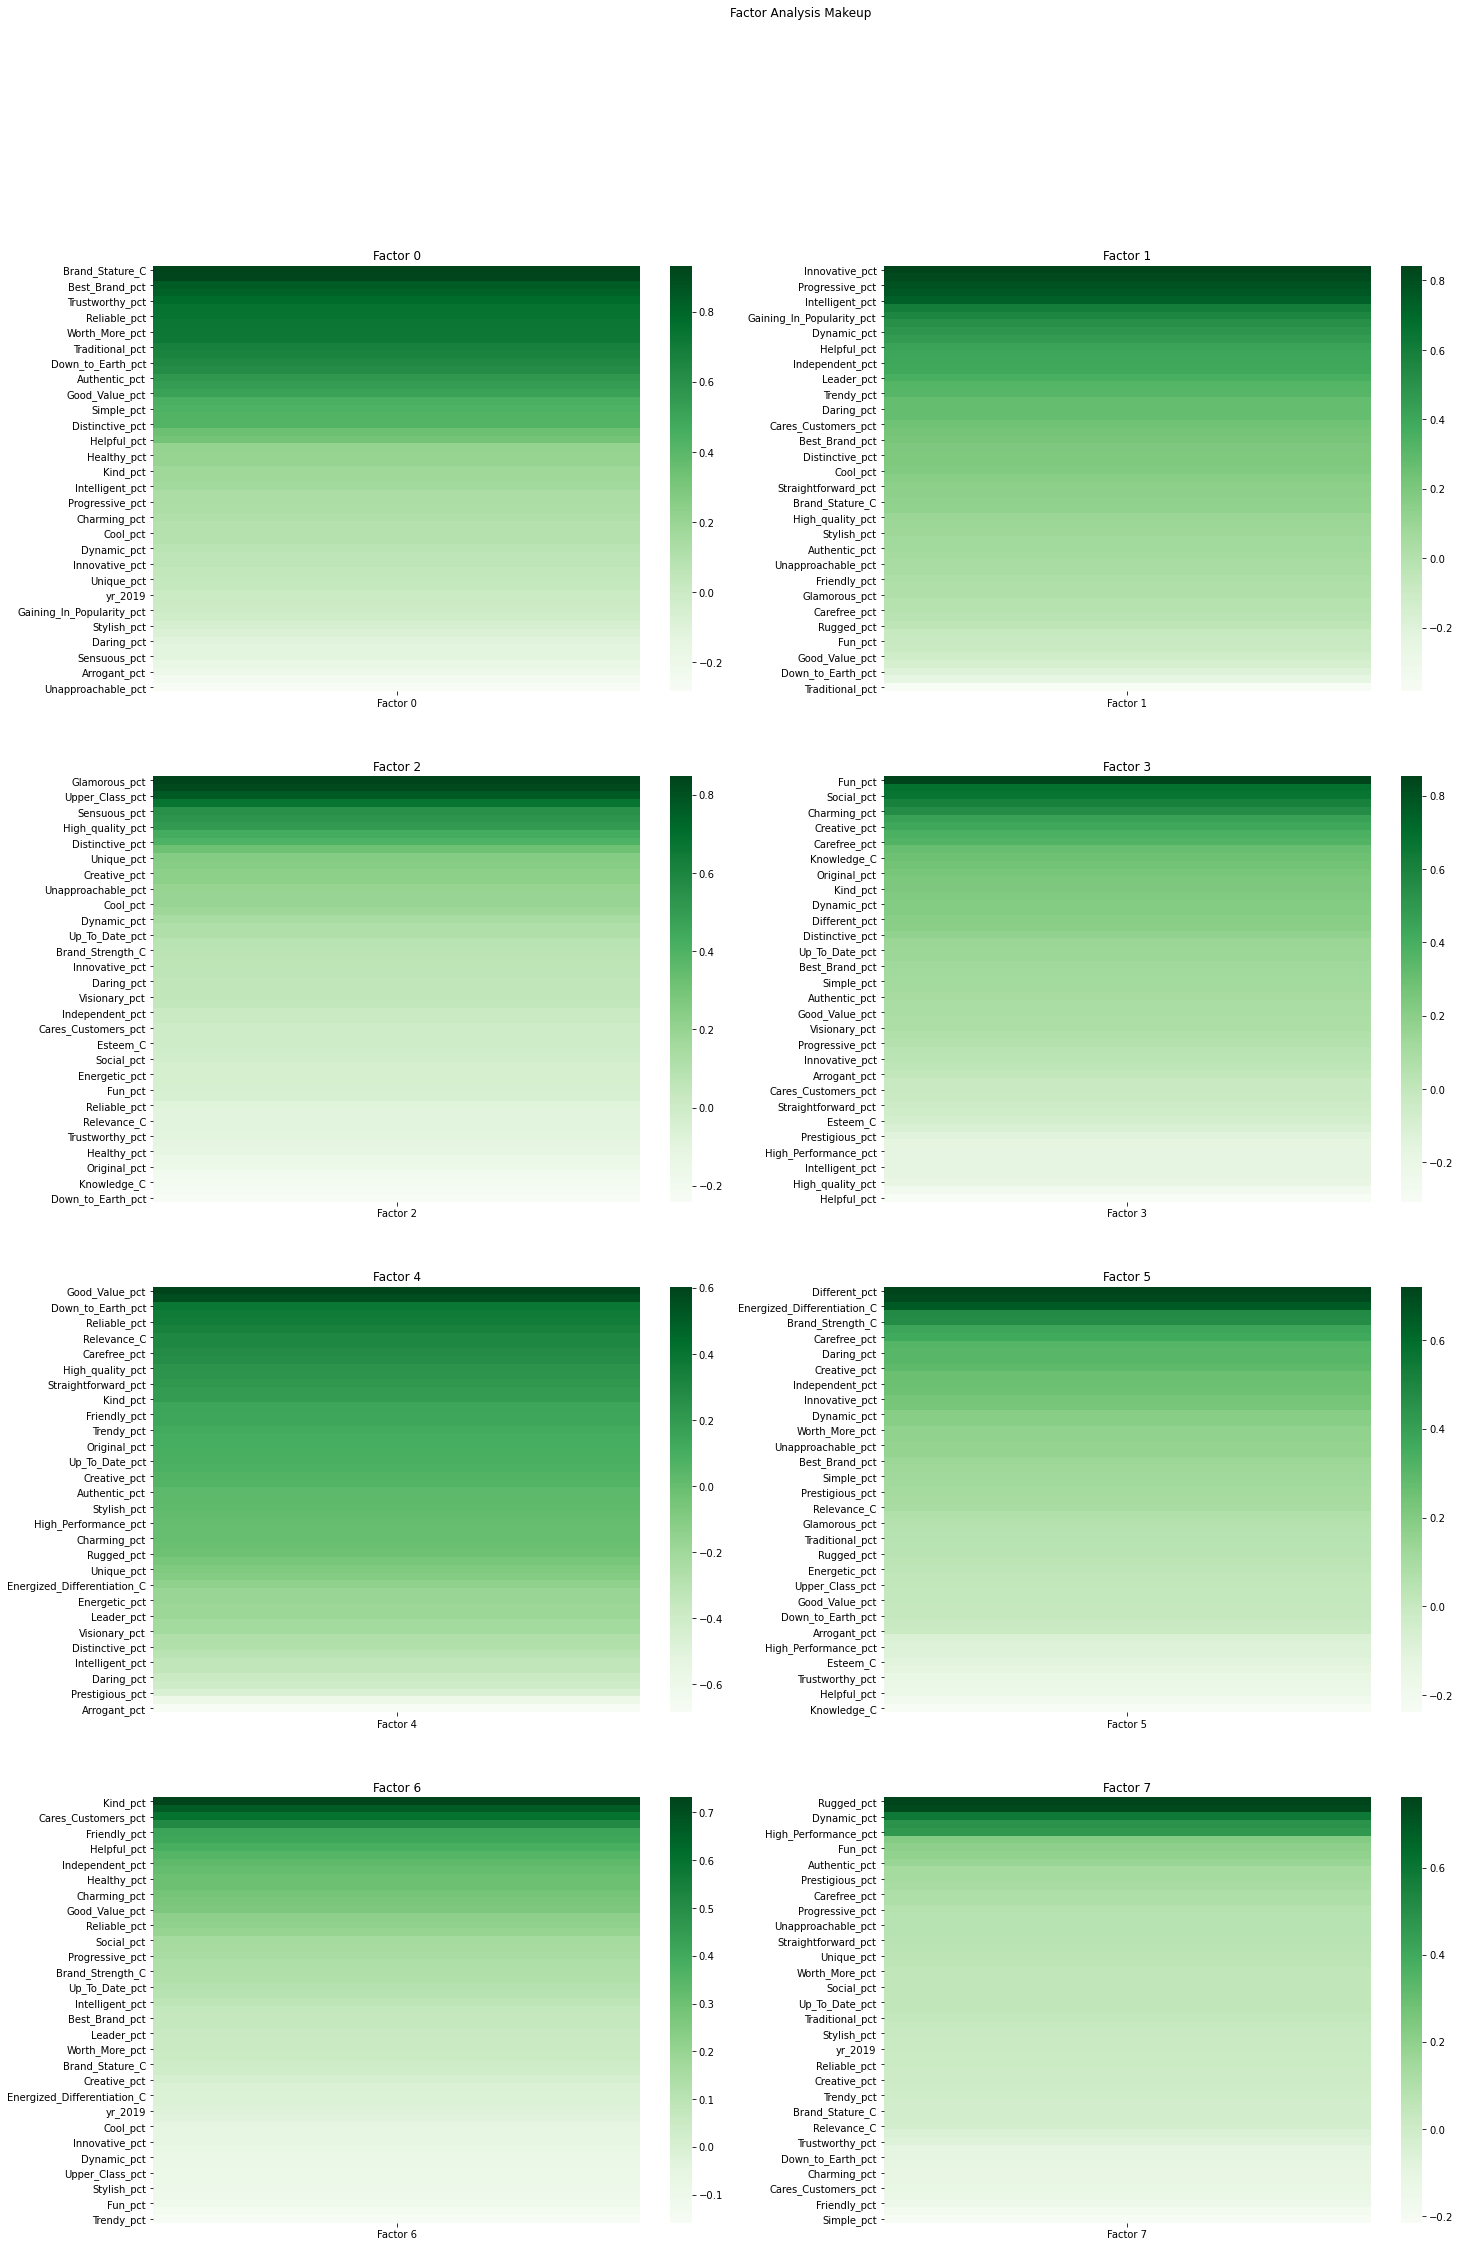

In [49]:
fig, axes = plt.subplots(4, 2, figsize=(24, 36))
fig.suptitle('Factor Analysis Makeup')

ax_ar = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
for i in range(8):
    sns.heatmap(loadings[['Factor {}'.format(i)]].sort_values(by='Factor {}'.format(i), ascending=False), cmap='Greens', fmt='g', ax=axes[ax_ar[i][0], ax_ar[i][1]]).set_title('Factor {}'.format(i))
    
plt.show()

This looks promising.   
I'll take a bit more time with the right names but at first glance these feel distinct and separate.   
Something like the below as a placeholder for now:   

- Factor 0: Reputation
- Factor 1: Cutting Edge
- Factor 2: Prestige
- Factor 3: Charisma
- Factor 4: Approachable
- Factor 5: Unique
- Factor 6: Thoughtful
- Factor 7: Advanced

## Hypothesis on Data Leakage

In the dataset there are a few features that strongly make-up the first factor (Factor 0).   
These features, denoted with '_C' are not part of the raw survey data and are a rollup of some the attribute scores. 
One hypothesis is that this strong makeup could actually be data leakage—redundant information calculated from the other features and could be muddying up the features.   
I'd like to try factor analysis one more time without these features to see what impact that makes.

In [50]:
# Dropping the '_C' columns
BAV_feats = BAV_df.drop(['Recommend_to_a_friend_pct', 'Energized_Differentiation_C', 'Relevance_C', 'Esteem_C', 'Knowledge_C', 'Brand_Stature_C', 'Brand_Strength_C'], axis=1)

In [51]:
chi_square, p_val = calculate_bartlett_sphericity(BAV_feats)
chi_square, p_val

(302322.2594928528, 0.0)

In [52]:
# KMO test. Want a value above .6 for factorability
kmo_all, kmo_model = calculate_kmo(BAV_feats)
kmo_model

0.9069074802758929

Even better shape for factor analysis.

In [53]:
# Check Eigen Values
fa = FactorAnalyzer(rotation=None)
fa.fit(BAV_feats)

ev, v = fa.get_eigenvalues()
ev

array([10.78344926,  8.86476514,  4.71600484,  3.73967032,  2.89362819,
        2.12073941,  1.57993987,  1.43370412,  1.35124256,  1.07708102,
        0.94617805,  0.7168239 ,  0.6416415 ,  0.60053221,  0.52028567,
        0.47168314,  0.44843099,  0.44540254,  0.3728493 ,  0.35229472,
        0.30405228,  0.30180618,  0.27423625,  0.27040748,  0.25589235,
        0.23805652,  0.22911352,  0.21880097,  0.21107635,  0.20401937,
        0.18613922,  0.18198046,  0.18064869,  0.17311527,  0.1630031 ,
        0.15319761,  0.14513699,  0.14280618,  0.13384825,  0.1284523 ,
        0.12184925,  0.10619392,  0.10457784,  0.09765567,  0.09185407,
        0.08924901,  0.08625049,  0.07818705,  0.05204666])

In [54]:
ev_df = pd.DataFrame(data={'Eigen Value': ev})
ev_df

,Eigen Value
0,10.783449
1,8.864765
2,4.716005
3,3.739670
4,2.893628
5,2.120739
6,1.579940
7,1.433704
8,1.351243
9,1.077081


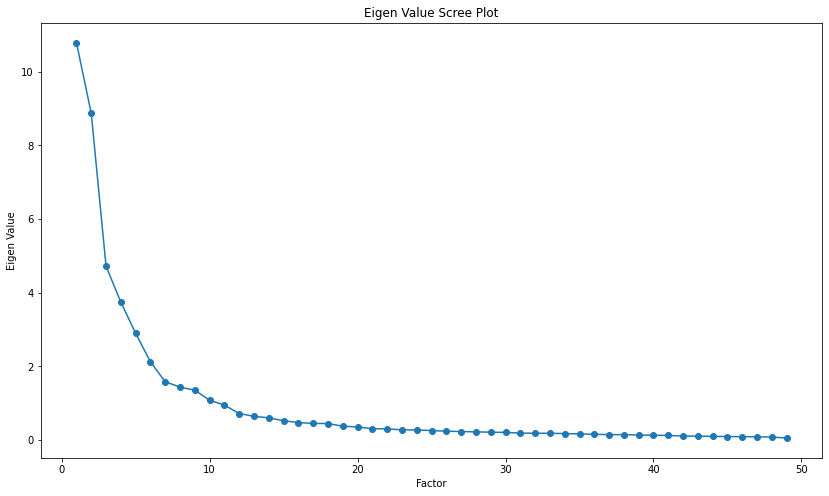

In [55]:
# Plot Eigen Values
plt.figure(figsize=(14, 8))
plt.scatter(range(1, 50), ev)
plt.plot(range(1, 50), ev)
plt.title('Eigen Value Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigen Value')
plt.show()

Still 10 Values > 1.  
Rerun with 10 factors.

In [56]:
# Run Factor Analysis on 10 Factors
fa = FactorAnalyzer(rotation='varimax', n_factors=10)
fa.fit(BAV_feats)

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [57]:
# Make DataFrame from fa.loadings_
factor_cols = ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7', 'Factor 8', 'Factor 9']
loadings = pd.DataFrame(data=fa.loadings_, columns=factor_cols, index=BAV_feats.columns)
loadings

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
Different_pct,-0.149119,0.239085,0.105033,0.110062,0.063782,0.778809,0.033441,0.087177,0.070352,0.049925
Distinctive_pct,0.429118,0.234885,0.386452,0.184312,-0.065160,0.399500,0.151255,0.132993,-0.309584,0.013262
Unique_pct,0.095278,0.314949,0.257459,0.222477,0.034997,0.725898,0.105682,0.030366,-0.134902,0.053670
Dynamic_pct,0.008404,0.492874,0.158945,0.196055,-0.091420,0.154900,0.629547,0.164747,-0.198255,0.049113
Innovative_pct,0.049446,0.817779,0.067206,-0.038183,-0.040049,0.246244,0.085359,-0.156591,0.053614,0.077552
Leader_pct,0.735391,0.442270,-0.025887,0.044897,0.039657,-0.248224,0.140545,0.153217,-0.133547,-0.001777
Reliable_pct,0.730742,0.260799,-0.119127,-0.257607,0.255847,-0.281294,-0.016829,-0.220774,0.165953,-0.017375
High_quality_pct,0.692537,0.127779,0.451006,-0.184422,-0.025492,-0.018388,0.037967,-0.277324,-0.129552,0.007111
Arrogant_pct,-0.238929,0.047301,0.159533,0.004442,-0.156474,-0.045737,0.129604,0.746841,-0.100067,-0.016407
Authentic_pct,0.626844,0.109211,0.186670,0.133326,0.227952,0.298115,0.164394,-0.017402,-0.132581,0.053573


In [58]:
# Get variance for each factor
variance_cols = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
variance = pd.DataFrame(data=fa.get_factor_variance(), columns=loadings.columns, index=variance_cols)
variance

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
SS Loadings,7.663295,5.933736,4.510540,3.498495,3.083211,2.893217,2.622643,2.408923,1.835202,1.413697
Proportion Variance,0.156394,0.121097,0.092052,0.071398,0.062923,0.059045,0.053523,0.049162,0.037453,0.028851
Cumulative Variance,0.156394,0.277490,0.369542,0.440940,0.503863,0.562908,0.616431,0.665593,0.703046,0.731897


So far this looks similar to the first pass.  
Let's drop the last 2 factors and see what impact that has.

In [59]:
# Run Factor Analysis on 8 Factors
fa = FactorAnalyzer(rotation='varimax', n_factors=8)
fa.fit(BAV_feats)

FactorAnalyzer(n_factors=8, rotation='varimax', rotation_kwargs={})

In [60]:
# Make DataFrame from fa.loadings_
factor_cols = ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7']
loadings = pd.DataFrame(data=fa.loadings_, columns=factor_cols, index=BAV_feats.columns)

In [61]:
# Get variance for each of the 8 factors
variance_cols = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
variance = pd.DataFrame(data=fa.get_factor_variance(), columns=loadings.columns, index=variance_cols)
variance

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
SS Loadings,7.170663,5.975130,5.095241,4.237310,3.667243,3.299887,2.304192,1.979373
Proportion Variance,0.146340,0.121941,0.103985,0.086476,0.074842,0.067345,0.047024,0.040395
Cumulative Variance,0.146340,0.268282,0.372266,0.458742,0.533583,0.600928,0.647952,0.688348


Pretty good.  
About 69% of the variance explained.

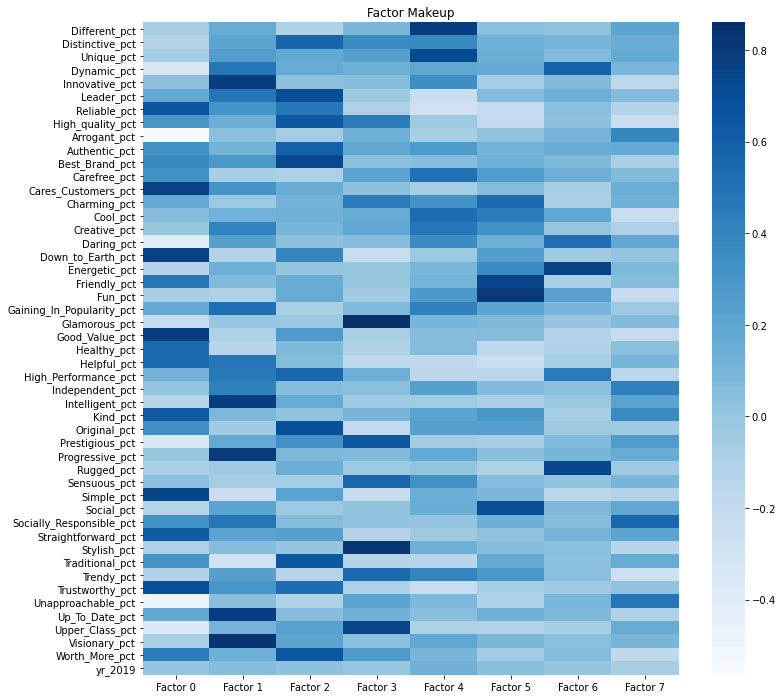

In [62]:
# Visualize in Blue this time
plt.figure(figsize=(12, 12))
sns.heatmap(loadings, cmap='Blues', fmt='g').set_title('Factor Makeup')
plt.show()

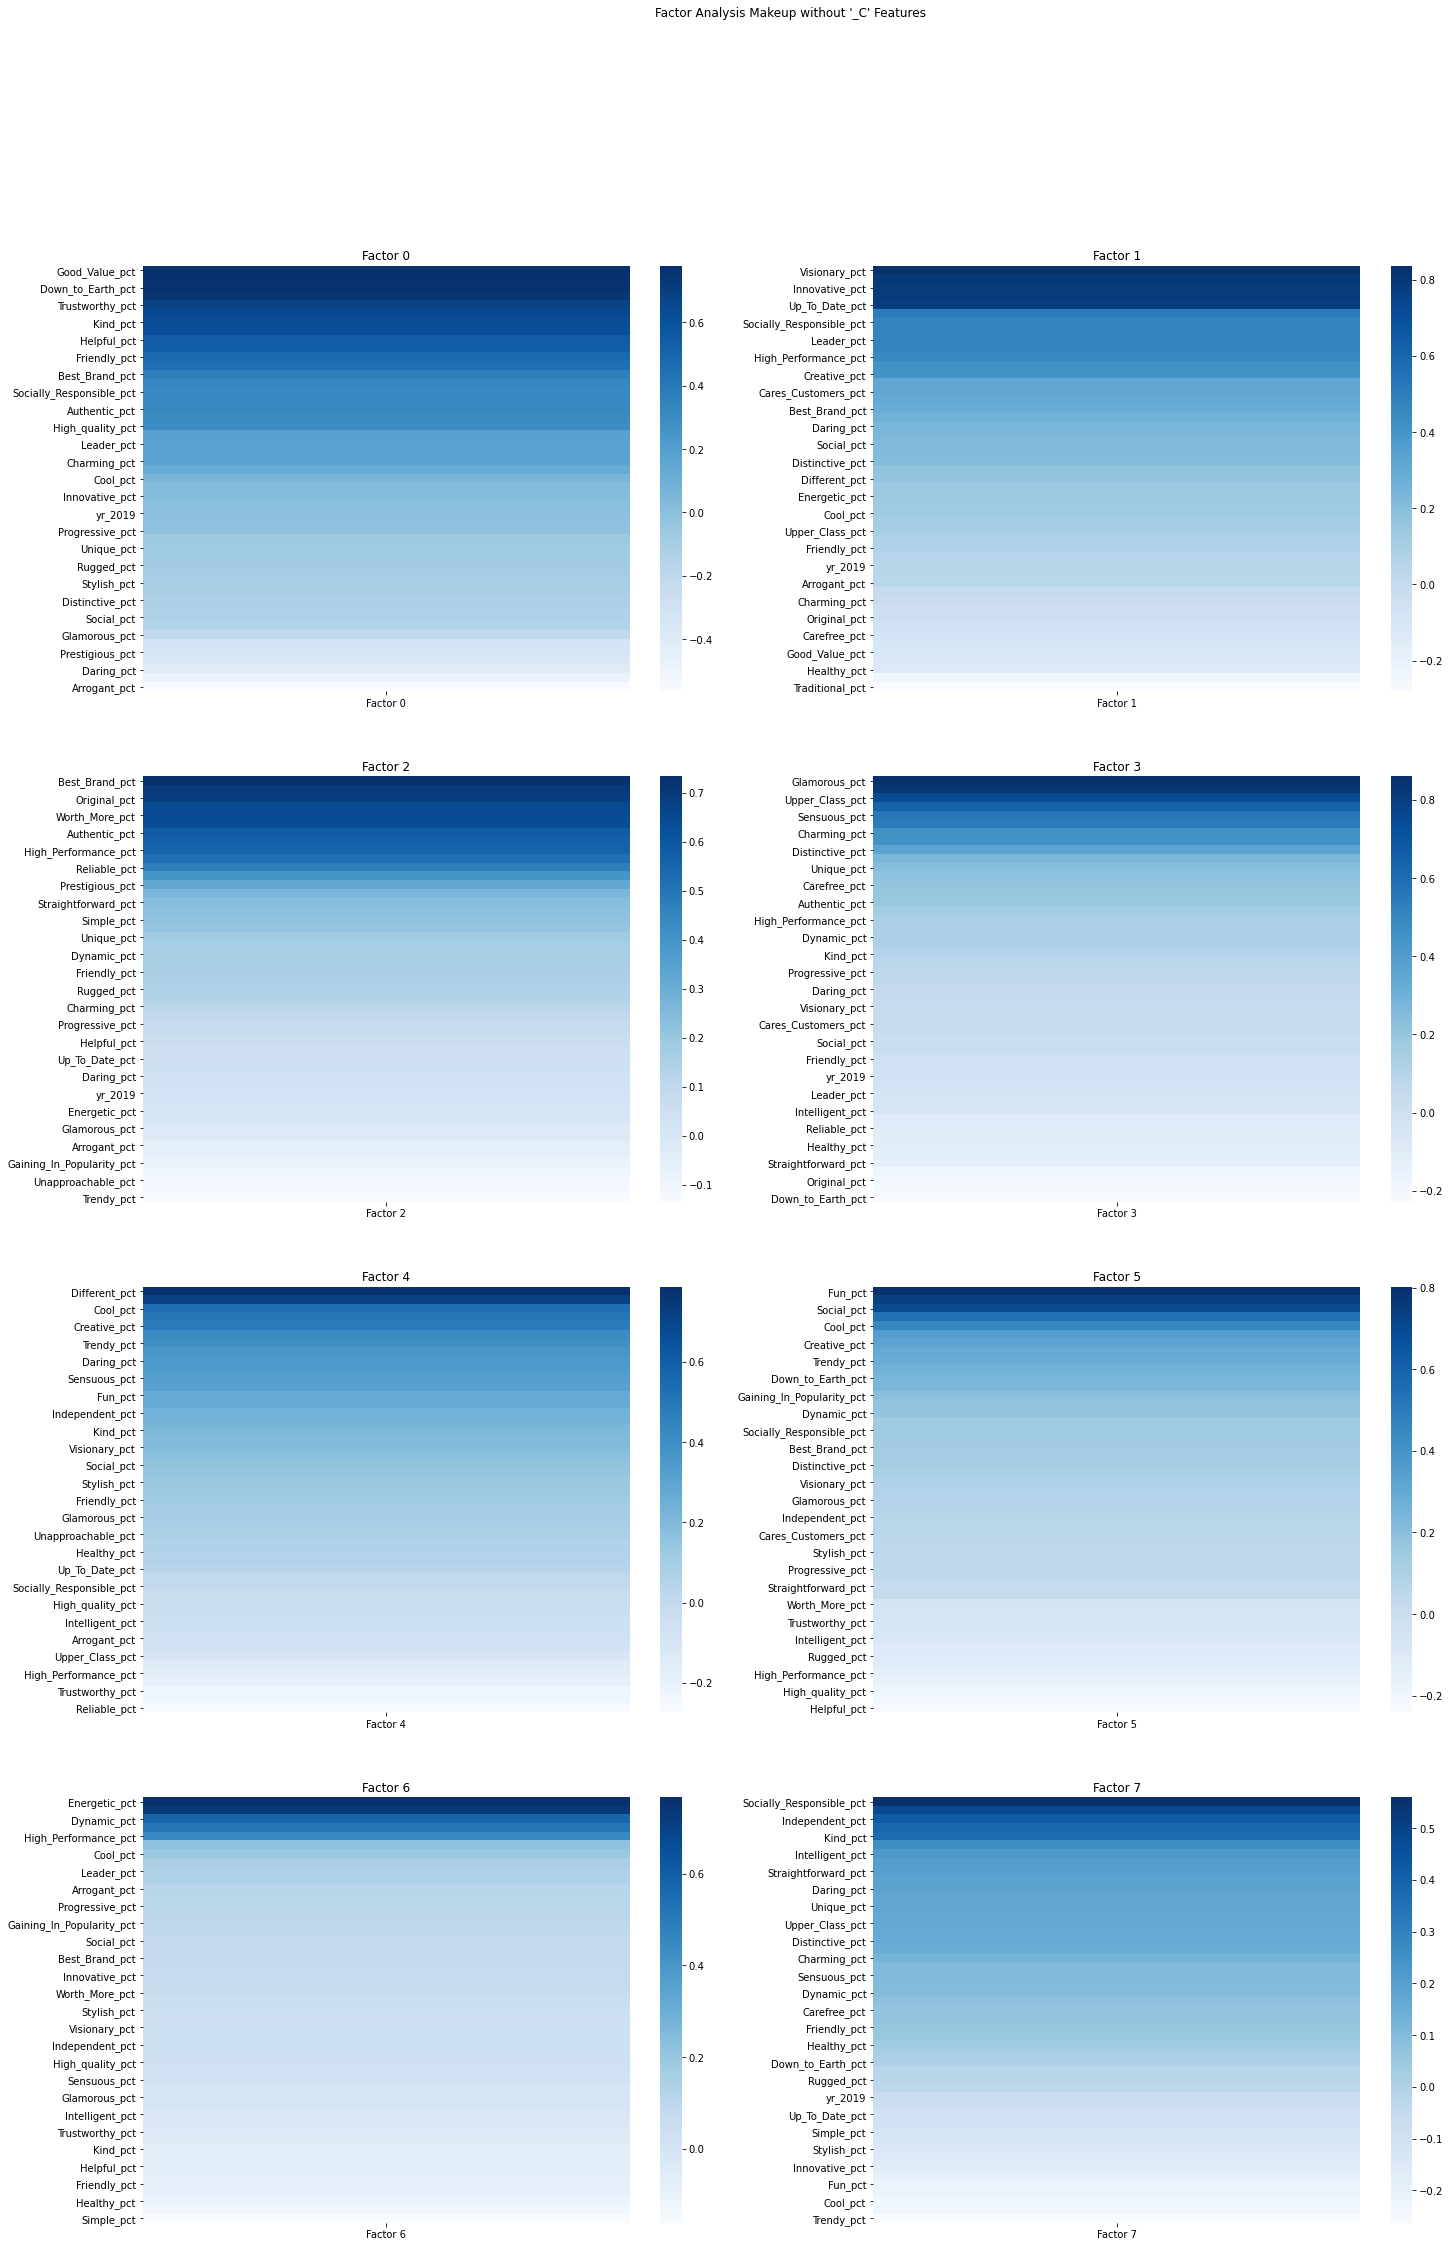

In [63]:
# Inspect Factors and Makekup
fig, axes = plt.subplots(4, 2, figsize=(24, 36))
fig.suptitle("Factor Analysis Makeup without '_C' Features")

ax_ar = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
for i in range(8):
    sns.heatmap(loadings[['Factor {}'.format(i)]].sort_values(by='Factor {}'.format(i), ascending=False), cmap='Blues', fmt='g', ax=axes[ax_ar[i][0], ax_ar[i][1]]).set_title('Factor {}'.format(i))
    
plt.show()

This looks pretty clear.
I'll take a bit more time with the right names but at first glance these feel distinct and separate with 'Factor 0' changing the most and most factors changing (for the better).
Something like the below as a placeholder for now:

- Factor 0: Service
- Factor 1: Cutting Edge
- Factor 2: Quality
- Factor 3: Prestige
- Factor 4: Uniqueness
- Factor 5: Charisma
- Factor 6: Powerful
- Factor 7: Thoughtful

## Next Steps

The Factor Analysis has been insightful and an appropriate trade-off in how to cluster the most influential factors. Will retain this 8 factor reduced dataset for the modeling phase.

I will reatin the PCA 7 reduced dataset for prediction purposes, in case there is a need for a separate prediction model.

I'm specifically interested to explore the effects of: High Correlation Filtering, Low Variance Filtering, and Random Forrests for Column Selection as outlined in this article:   
https://thenewstack.io/3-new-techniques-for-data-dimensionality-reduction-in-machine-learning/

### File Save Outs

In [211]:
# Assembling standard scaled dataset for save out
X_ = BAV_df.drop(['Recommend_to_a_friend_pct'], axis=1)
Xs_df = pd.DataFrame(data=scaler.transform(X_), columns=X_.columns)
Xs_df.index = y.index
BAV_scaled = pd.concat([y, Xs_df], axis=1)
BAV_scaled.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Acura,9.632626,-0.002347,-0.787306,0.276346,0.782062,0.408922,-0.532561,-0.534627,0.374604,-0.505916,...,1.700738,-0.953525,0.524561,0.172321,0.111888,0.067217,1.632785,0.832706,0.012613,-0.977609
Alfa Romeo,5.360558,1.509067,-1.696354,-0.596668,-0.322769,-0.512688,-0.498050,0.686925,2.491879,1.336199,...,2.043090,-0.756703,0.596944,-1.014161,2.144682,-0.124812,4.041739,-0.315579,0.703253,-0.977609
Aston Martin,6.165359,1.560737,-1.847191,-0.615000,-0.120060,-0.449481,-0.606405,0.667869,2.747290,1.311986,...,1.906571,-1.281172,-0.023276,-1.002630,1.842162,-1.111623,5.075575,-0.077605,0.767481,-0.977609
Audi,8.403893,1.530181,-1.090829,0.273648,0.732929,0.381005,0.029230,0.035036,1.816371,0.858114,...,2.380227,-0.463282,0.821769,-0.531731,0.564688,0.037198,3.106204,0.340826,0.803661,-0.977609
Bentley,6.453038,1.672423,-1.776480,0.103549,0.272025,0.048799,-0.500444,0.725951,3.061281,2.035984,...,2.549381,0.205497,0.061694,-0.477410,2.657441,-0.639585,6.079881,-0.164264,1.481469,-0.977609


In [67]:
# Reminder of unscaled dataset
BAV_df.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Acura,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,8.301122,...,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,0
Alfa Romeo,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,13.124450,...,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,0
Aston Martin,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,13.061050,...,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,0
Audi,8.403893,0.773740,1.970076,0.536370,3.247704,1.741970,1.524328,9.503444,16.048050,11.872650,...,18.800541,8.386318,15.85582,12.400040,6.730000,10.951970,21.809719,11.357830,8.388798,0
Bentley,6.453038,0.790917,1.605834,0.500165,2.720615,1.360756,1.270082,11.227820,19.309050,14.956740,...,19.569870,11.032830,12.52582,12.685470,11.473560,9.141562,34.941780,9.720911,10.133530,0


In [216]:
# Assemble 8 Factor DataFrame
# Run twice for Green and Blue outputs
X_df = pd.DataFrame(data=fa.transform(BAV_feats), columns=factor_cols, index=BAV_feats.index)
BAV_factors_df = pd.concat([y, X_df], axis=1)
BAV_factors_df.head()

,Recommend_to_a_friend_pct,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
Acura,9.632626,-0.618549,0.725931,0.184069,1.151304,-1.081142,-0.581566,0.234125,-1.080806
Alfa Romeo,5.360558,-1.948397,-0.458633,1.153742,2.662952,-0.041473,-0.968878,0.392144,0.306819
Aston Martin,6.165359,-2.290844,-0.629300,1.825844,3.102590,-0.196054,-1.606450,0.145108,0.025176
Audi,8.403893,-1.010458,0.518512,0.905139,2.177453,-0.312720,-0.916725,1.086126,-0.497146
Bentley,6.453038,-2.106252,-0.747256,2.729285,3.752966,-0.246517,-1.509300,-0.336117,0.899006


In [213]:
BAV_factors_df.shape

(6058, 9)

In [193]:
BAV_df.to_csv("../data/BAV_unscaled.csv")
BAV_scaled.to_csv("../data/BAV_scaled.csv")
BAV_pca7_df.to_csv("../data/BAV_pca7.csv")
BAV_factors_df.to_csv("../data/BAV_factors.csv") # Green

In [214]:
BAV_factors_df.to_csv("../data/BAV_factors_blue.csv") # Blue

In [2]:
# Load the Joined BAV data from EDA stage
BAV_factors = pd.read_csv('../data/BAV_factors_blue.csv', header=0, index_col=0)
BAV_factors.head()

,Recommend_to_a_friend_pct,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
Acura,9.632626,-0.618549,0.725931,0.184069,1.151304,-1.081142,-0.581566,0.234125,-1.080806
Alfa Romeo,5.360558,-1.948397,-0.458633,1.153742,2.662952,-0.041473,-0.968878,0.392144,0.306819
Aston Martin,6.165359,-2.290844,-0.629300,1.825844,3.102590,-0.196054,-1.606450,0.145108,0.025176
Audi,8.403893,-1.010458,0.518512,0.905139,2.177453,-0.312720,-0.916725,1.086126,-0.497146
Bentley,6.453038,-2.106252,-0.747256,2.729285,3.752966,-0.246517,-1.509300,-0.336117,0.899006


In [15]:
BAV_reco_sort = BAV_factors.sort_values(by='Factor 0', ascending=False)
BAV_reco_sort.head(150)

,Recommend_to_a_friend_pct,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
Habitat for Humanity,21.626110,3.555068,3.368674,-0.181257,-0.263711,-0.472166,1.765544,0.585397,5.081450
Habitat for Humanity,20.801350,3.439340,3.117271,0.113521,-0.382085,0.452201,1.151145,0.177651,5.091843
Salvation Army,26.922840,3.421040,1.054905,0.254736,-0.217080,-1.300876,1.786200,-0.348178,5.107222
Make-A-Wish Foundation,19.966339,3.249780,2.963914,0.300539,0.272404,-0.087841,1.989828,-0.523521,4.705012
Band-Aid,47.218048,3.011355,0.452538,2.992273,0.190897,-0.892930,-0.543041,0.052558,0.231187
...,...,...,...,...,...,...,...,...,...
Campbell`s,38.325199,1.879169,-0.494316,2.715113,-0.410970,-0.331178,0.302180,-0.551666,0.672646
Tylenol,33.271091,1.873678,0.179282,1.632732,-0.429946,-1.084363,-1.452829,0.032474,0.122272
Quilted Northern,26.685570,1.869236,-0.634916,0.400069,0.261849,-0.948680,-0.965028,0.204822,-0.486715
Florida`s Natural,21.074110,1.867896,-0.926626,0.813206,-0.043053,0.122955,-0.308334,-0.005958,-0.189317


In [28]:
minute_maid = BAV_factors.loc[BAV_factors.index == "Minute Maid"]
print(minute_maid)

             Recommend_to_a_friend_pct  Factor 0  Factor 1  Factor 2  \
Minute Maid                  32.329201  1.667616 -0.824169  0.900276   
Minute Maid                  28.942240  1.671266 -0.806588  1.336271   

             Factor 3  Factor 4  Factor 5  Factor 6  Factor 7  
Minute Maid -0.183230 -0.335386  0.154005 -0.314881 -0.298532  
Minute Maid -0.261396 -0.051932  0.472717 -0.151310 -0.359871  


In [29]:
ocean_spray = BAV_factors.loc[BAV_factors.index == "Ocean Spray"]
print(ocean_spray)

             Recommend_to_a_friend_pct  Factor 0  Factor 1  Factor 2  \
Ocean Spray                  28.350229  1.105995 -0.709392  1.397628   
Ocean Spray                  25.583750  1.253765 -0.757143  1.533576   

             Factor 3  Factor 4  Factor 5  Factor 6  Factor 7  
Ocean Spray -0.244702 -0.027815  0.221415 -0.442613 -0.235390  
Ocean Spray -0.503912  0.309329 -0.428192 -0.782806 -0.454919  


In [30]:
simply_orange = BAV_factors.loc[BAV_factors.index == "Simply Orange"]
print(simply_orange)

               Recommend_to_a_friend_pct  Factor 0  Factor 1  Factor 2  \
Simply Orange                   25.42985  1.585742 -0.600424  0.329197   
Simply Orange                   25.66024  1.760576 -0.785238  0.442134   

               Factor 3  Factor 4  Factor 5  Factor 6  Factor 7  
Simply Orange -0.042351 -0.038372 -0.095449 -0.098013 -0.410763  
Simply Orange  0.019246  0.153289 -0.634172 -0.271013 -0.475536  


In [31]:
juicy_juice = BAV_factors.loc[BAV_factors.index == "Juicy Juice"]
print(juicy_juice)

             Recommend_to_a_friend_pct  Factor 0  Factor 1  Factor 2  \
Juicy Juice                   17.55361  0.870454 -1.204927 -0.349719   
Juicy Juice                   18.84446  1.194605 -0.800952  0.128305   

             Factor 3  Factor 4  Factor 5  Factor 6  Factor 7  
Juicy Juice -0.329143  0.078612  0.729876 -0.645969 -0.514785  
Juicy Juice -0.301954  0.053871  1.153673 -0.403383 -0.365116  


In [32]:
welchs = BAV_factors.loc[BAV_factors.index == "Welch`s"]
print(welchs)

         Recommend_to_a_friend_pct  Factor 0  Factor 1  Factor 2  Factor 3  \
Welch`s                  28.321850  1.434200 -0.843927  1.642341 -0.471730   
Welch`s                  26.706829  1.724421 -1.114737  1.946713 -0.412256   

         Factor 4  Factor 5  Factor 6  Factor 7  
Welch`s -0.296974  0.523207 -0.701249 -0.239887  
Welch`s  0.337308  0.167700 -0.496805  0.133287  
